1). Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Для ресемплинга по неделям удалим ненужные для недельных интервалов признаки.

In [3]:
data_w = data.drop(['Time', 'year', 'dayofmonth', 'dayofyear', 'dayofweek', 'hour',
                    'is_holiday', 'is_prev_holiday','is_next_holiday'], axis=1)
data_w = data_w.resample('W').mean()
data_w.head()

,PJME_MW,month,quarter,weekofyear
Date,,,,
2002-01-06,32392.160839,1.000000,1.0,1.0
2002-01-13,31487.386905,1.000000,1.0,2.0
2002-01-20,31452.880952,1.000000,1.0,3.0
2002-01-27,30141.529762,1.000000,1.0,4.0
2002-02-03,29196.488095,1.428571,1.0,5.0


Далее строим модели предсказания на 4 шага вперед и на 1 шаг вперед, для начала сгенерировав несколько признаков.

In [4]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE 

scl = StandardScaler()
tsne_ =TSNE(n_components=2)

X = data_w.iloc[:,:-1].values
Xscale = scl.fit_transform(X)
X_t = tsne_.fit_transform(Xscale)

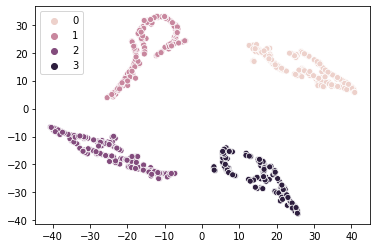

In [5]:
clast_0 = DBSCAN(eps=5, leaf_size=15 )
X_clast =clast_0.fit_predict(X_t)

sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
plt.show()

In [6]:
data_w['DBScan clast'] = X_clast
data_w.tail()

,PJME_MW,month,quarter,weekofyear,DBScan clast
Date,,,,,
2018-07-08,38459.982143,7.000000,3.0,27.0,2
2018-07-15,36420.035714,7.000000,3.0,28.0,2
2018-07-22,35612.095238,7.000000,3.0,29.0,2
2018-07-29,36581.821429,7.000000,3.0,30.0,2
2018-08-05,36568.804124,7.505155,3.0,31.0,2


In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
Xpca=pca.fit_transform(Xscale[:,1:])
Xpca.shape

(866, 2)

In [8]:
data_w['pca1']=Xpca[:,0]
data_w['pca2']=Xpca[:,1]
data_w.head()

,PJME_MW,month,quarter,weekofyear,DBScan clast,pca1,pca2
Date,,,,,,,
2002-01-06,32392.160839,1.000000,1.0,1.0,0,-2.091617,-0.183124
2002-01-13,31487.386905,1.000000,1.0,2.0,0,-2.091617,-0.183124
2002-01-20,31452.880952,1.000000,1.0,3.0,0,-2.091617,-0.183124
2002-01-27,30141.529762,1.000000,1.0,4.0,0,-2.091617,-0.183124
2002-02-03,29196.488095,1.428571,1.0,5.0,0,-2.001938,-0.093445


In [9]:
data_w['d_m4'] = data_w['PJME_MW'].rolling(window=4).mean()
data_w['d_m4'] = data_w['d_m4'].fillna(0)
data_w.head()

,PJME_MW,month,quarter,weekofyear,DBScan clast,pca1,pca2,d_m4
Date,,,,,,,,
2002-01-06,32392.160839,1.000000,1.0,1.0,0,-2.091617,-0.183124,0.000000
2002-01-13,31487.386905,1.000000,1.0,2.0,0,-2.091617,-0.183124,0.000000
2002-01-20,31452.880952,1.000000,1.0,3.0,0,-2.091617,-0.183124,0.000000
2002-01-27,30141.529762,1.000000,1.0,4.0,0,-2.091617,-0.183124,31368.489615
2002-02-03,29196.488095,1.428571,1.0,5.0,0,-2.001938,-0.093445,30569.571429


In [10]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

data_w['exp_0_05'] = exponential_smoothing(data_w['PJME_MW'], 0.05)
data_w['exp_0_08'] = exponential_smoothing(data_w['PJME_MW'], 0.08)

data_w.head()

,PJME_MW,month,quarter,weekofyear,DBScan clast,pca1,pca2,d_m4,exp_0_05,exp_0_08
Date,,,,,,,,,,
2002-01-06,32392.160839,1.000000,1.0,1.0,0,-2.091617,-0.183124,0.000000,32392.160839,32392.160839
2002-01-13,31487.386905,1.000000,1.0,2.0,0,-2.091617,-0.183124,0.000000,32346.922142,32319.778924
2002-01-20,31452.880952,1.000000,1.0,3.0,0,-2.091617,-0.183124,0.000000,32302.220083,32250.427087
2002-01-27,30141.529762,1.000000,1.0,4.0,0,-2.091617,-0.183124,31368.489615,32194.185567,32081.715301
2002-02-03,29196.488095,1.428571,1.0,5.0,0,-2.001938,-0.093445,30569.571429,32044.300693,31850.897124


In [11]:
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

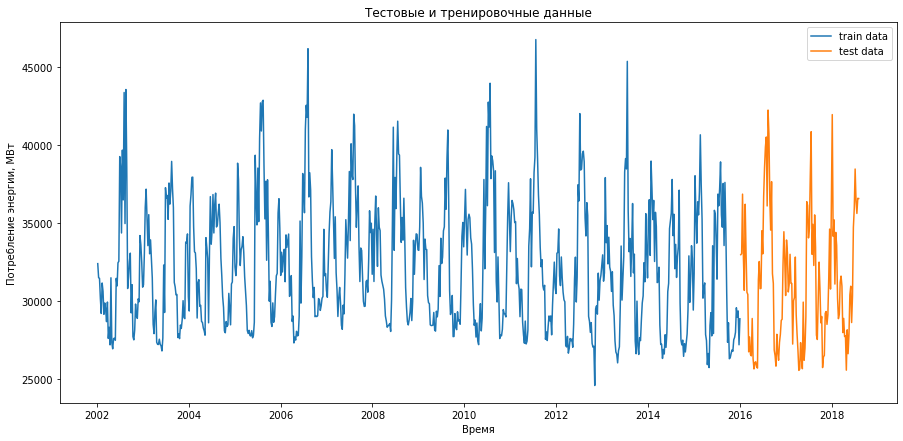

In [12]:
train, test = split_data( data_w, '01-06-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

Сначала сделаем предсказание на 4 шага вперед.

In [13]:
X_train = train.iloc[:-4,:]
y_train = train['PJME_MW'].values[4:]
X_test = test.iloc[:-4,:]
y_test = test['PJME_MW'].values[4:]
X_train.drop(['PJME_MW'], axis=1)
X_test.drop(['PJME_MW'], axis=1)

,month,quarter,weekofyear,DBScan clast,pca1,pca2,d_m4,exp_0_05,exp_0_08
Date,,,,,,,,,
2016-01-10,1.000000,1.000000,1.0,0,-2.091617,-0.183124,29592.415179,30480.919886,29896.640489
2016-01-17,1.000000,1.000000,2.0,0,-2.091617,-0.183124,30511.703869,30608.702761,30147.835440
2016-01-24,1.000000,1.000000,3.0,0,-2.091617,-0.183124,32926.691964,30920.722385,30683.936224
2016-01-31,1.000000,1.000000,4.0,0,-2.091617,-0.183124,33902.250000,31012.583587,30849.857041
2016-02-07,2.000000,1.000000,5.0,0,-1.882365,0.026128,33330.114583,30995.796372,30836.015620
...,...,...,...,...,...,...,...,...,...
2018-06-10,6.000000,2.000000,23.0,1,-0.401111,0.218888,29449.322917,30122.162119,29683.423380
2018-06-17,6.000000,2.000000,24.0,1,-0.401111,0.218888,30065.022321,30131.901037,29734.104748
2018-06-24,6.000000,2.000000,25.0,1,-0.401111,0.218888,31147.336310,30360.888425,30132.308273


In [14]:
from sklearn.ensemble import GradientBoostingRegressor

In [15]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=24, n_estimators=100)

In [16]:
model_g.fit( X_train, y_train )

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=24, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
X_test_pred_g = model_g.predict(X_test)

In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

er_g_h4 = mean_absolute_percentage_error(y_true=X_test_pred_g, y_pred=X_test_pred_g)
er_g_h4

7.759789622874604

Cделаем предсказание на 1 шаг вперед.

In [21]:
train, test = split_data( data_w, '01-06-2016')

In [22]:
X_train = train.iloc[:-1,:]
y_train = train['PJME_MW'].values[1:]
X_test = test.iloc[:-1,:]
y_test = test['PJME_MW'].values[1:]
X_train.drop( columns = 'PJME_MW', inplace = True )
X_test.drop( columns = 'PJME_MW', inplace = True )

C:\Users\horne\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [23]:
model_g.fit( X_train, y_train )

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=24, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [24]:
X_test_pred_g = model_g.predict(X_test)

In [25]:
er_g_h1 = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_g)
er_g_h1

6.7902396443848865

In [26]:
print('ошибка модели h=1 : {0}, ошибка модели h=4 : {1}'.format(er_g_h1, er_g_h4))

ошибка модели h=1 : 6.7902396443848865, ошибка модели h=4 : 7.759789622874604


Вывод: ошибка шага 4 от 1 отличается не очень сильно (около 1%), но в общем недельный ресемпл предсказывает хуже обычного дневного\почасового, т.к. там сильная корреляция от времени суток и статуса дня (выходной, праздник и т.п.)